## BitCoin Forecasting in PyTorch with LSTM

In [166]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
 
import torch
import torch.nn as nn

data = pd.read_csv('BTC-USD.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
...,...,...,...,...,...,...,...
1548,2024-03-28,69452.773438,71546.023438,68895.507813,70744.953125,70744.953125,34374900617
1549,2024-03-29,70744.796875,70913.093750,69076.656250,69892.828125,69892.828125,25230851763
1550,2024-03-30,69893.445313,70355.492188,69601.062500,69645.304688,69645.304688,17130241883
1551,2024-03-31,69647.781250,71377.781250,69624.867188,71333.648438,71333.648438,20050941373


In [167]:
data = data[['Date','Close']]
data

,Date,Close
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383
...,...,...
1548,2024-03-28,70744.953125
1549,2024-03-29,69892.828125
1550,2024-03-30,69645.304688
1551,2024-03-31,71333.648438


In [168]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [169]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1553 entries, 0 to 1552
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
1553 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 12.3 KB


C:\Users\ivoto\AppData\Local\Temp\ipykernel_16960\4140636855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


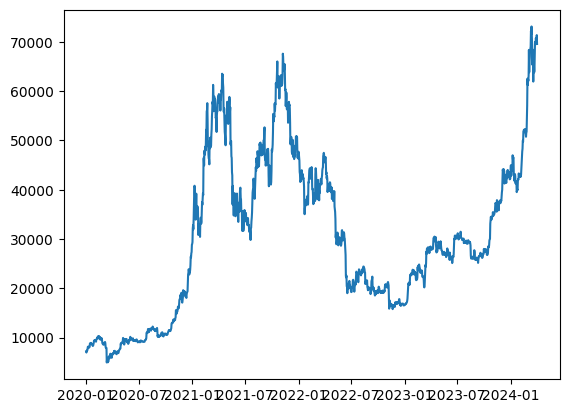

In [170]:
plt.plot(data['Date'],data['Close'])

In [171]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2020-01-08,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738,7344.884277,6985.470215,7200.174316
2020-01-09,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738,7344.884277,6985.470215
2020-01-10,8166.554199,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738,7344.884277
2020-01-11,8037.537598,8166.554199,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383,7410.656738
2020-01-12,8192.494141,8037.537598,8166.554199,7879.071289,8079.862793,8163.692383,7769.219238,7411.317383
...,...,...,...,...,...,...,...,...
2024-03-28,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719,65491.390625
2024-03-29,69892.828125,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125,63778.761719
2024-03-30,69645.304688,69892.828125,70744.953125,69455.343750,69987.835938,69958.812500,67234.171875,64062.203125


En el cuadro aterior vemos para el dia actual, y los precios de los 7 (n-dias) anteriores

In [172]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 8079.862793,  8163.692383,  7769.219238, ...,  7344.884277,
         6985.470215,  7200.174316],
       [ 7879.071289,  8079.862793,  8163.692383, ...,  7410.656738,
         7344.884277,  6985.470215],
       [ 8166.554199,  7879.071289,  8079.862793, ...,  7411.317383,
         7410.656738,  7344.884277],
       ...,
       [69645.304688, 69892.828125, 70744.953125, ..., 69958.8125  ,
        67234.171875, 64062.203125],
       [71333.648438, 69645.304688, 69892.828125, ..., 69987.835938,
        69958.8125  , 67234.171875],
       [69539.515625, 71333.648438, 69645.304688, ..., 69455.34375 ,
        69987.835938, 69958.8125  ]])

#### Normalizamos los datos

In [173]:
#Normalizamos los datos 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np.shape

(1546, 8)

- Hasta ahora, leemos el CSV, lo convertimos a DataFrame con pandas
- Luego lo analizamos y para trabajar con el lo pasamos de DataFrame a una matriz de NumPy 
- Y por ultimo Escalamos las variables con un rango de -1 a 1 

#### Division del conjunto de entrenamiento y test

In [174]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1546, 7), (1546,))

In [175]:
X = dc(np.flip(X, axis=1 ))
X

array([[-0.93453832, -0.9408427 , -0.93028919, ..., -0.92833851,
        -0.9178294 , -0.90624645],
       [-0.9408427 , -0.93028919, -0.92835791, ..., -0.9178294 ,
        -0.90624645, -0.90870795],
       [-0.93028919, -0.92835791, -0.92833851, ..., -0.90624645,
        -0.90870795, -0.91460381],
       ...,
       [ 0.73510681,  0.82824563,  0.90824951, ...,  0.8934661 ,
         0.93133303,  0.906312  ],
       [ 0.82824563,  0.90824951,  0.90910172, ...,  0.93133303,
         0.906312  ,  0.89904395],
       [ 0.90824951,  0.90910172,  0.8934661 , ...,  0.906312  ,
         0.89904395,  0.94861894]])

In [176]:
split_index = int(len(X) * 0.95)

split_index

1468

In [177]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1468, 7), (78, 7), (1468,), (78,))

#### Agregamos un dimension

In [178]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1468, 7, 1), (78, 7, 1), (1468, 1), (78, 1))

#### Convertimos a los conjuntos a Tensores de Pytorch 

In [179]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1468, 7, 1]),
 torch.Size([78, 7, 1]),
 torch.Size([1468, 1]),
 torch.Size([78, 1]))

In [180]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [181]:
x_sample, y_sample = train_dataset[10]
print(x_sample.shape)  # Imprimirá torch.Size([7, 1])
print(y_sample.shape)  # Imprimirá torch.Size([1])

torch.Size([7, 1])
torch.Size([1])


In [182]:
from torch.utils.data import DataLoader

batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [183]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


#### Creamos el modelo

In [184]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Funcion y Bucle de entrenamiento 

In [185]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()


In [186]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


In [187]:
learning_rate = 0.01
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1



Val Loss: 0.080
***************************************************

Epoch: 2

Val Loss: 0.022
***************************************************

Epoch: 3

Val Loss: 0.013
***************************************************

Epoch: 4

Val Loss: 0.009
***************************************************

Epoch: 5

Val Loss: 0.008
***************************************************

Epoch: 6

Val Loss: 0.007
***************************************************

Epoch: 7

Val Loss: 0.006
***************************************************

Epoch: 8

Val Loss: 0.006
***************************************************

Epoch: 9

Val Loss: 0.006
***************************************************

Epoch: 10

Val Loss: 0.006
***************************************************

Epoch: 11

Val Loss: 0.006
***************************************************

Epoch: 12

Val Loss: 0.005
***************************************************

Epoch: 13

Val Loss: 0.004
*******************************

### Visualizacion

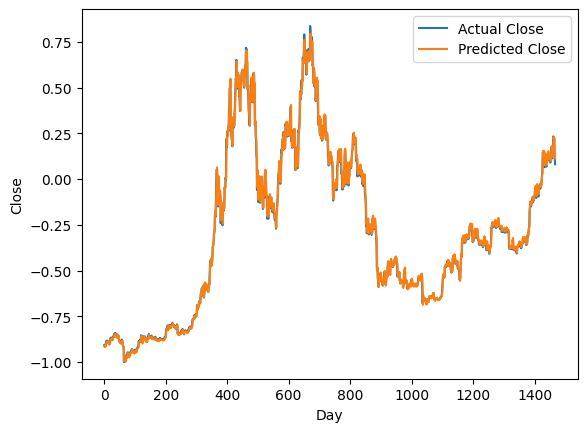

In [188]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy() #Es porque numpy no usa GPU 

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

##### Anti-transformada de los Precios 

In [189]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 7998.391021  ,  7939.84821474,  7733.36911742, ...,
       46582.06680139, 43246.11084708, 42860.56465159])

In [190]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 8079.86376967,  7879.07046987,  8166.55340504, ...,
       42853.16788779, 42842.38293877, 41796.26952682])

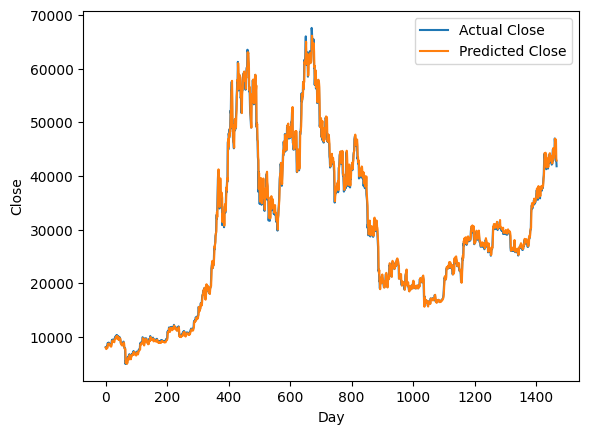

In [191]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [192]:
X_test.shape


torch.Size([78, 7, 1])

In [193]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([41950.61274342, 42591.52351236, 43314.08414023, 43012.17636112,
       41595.85480654, 41777.73587714, 41884.67038222, 41792.78568177,
       39902.17224416, 40025.84595229, 40316.40015188, 40224.03182371,
       41978.55201352, 42424.91553725, 42337.59053787, 43460.39852761,
       43253.2624984 , 42848.46558506, 43253.09426903, 43404.70673978,
       43230.55127954, 42825.19182544, 42854.90778039, 43265.68076939,
       44453.3801308 , 45478.35677825, 47252.65800173, 48001.56136998,
       48515.99511541, 50075.60166   , 50022.7679953 , 51922.16945108,
       52207.24287478, 52406.85882273, 51901.00553645, 52277.41304561,
       51960.97537436, 52426.80478716, 52026.209802  , 51470.14245892,
       50860.64871538, 51646.54529102, 51886.9808399 , 54558.71293603,
       57123.62673982, 61821.33373629, 61141.41709725, 62228.95527914,
       61820.9764709 , 62822.61871496, 66643.76086311, 63189.88550787,
       65315.2695035 , 65717.05503498, 66757.08909925, 66887.77312574,
      

In [194]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([42511.9687815 , 43154.94524473, 42742.65235538, 41262.05855381,
       41618.40616944, 41665.58600782, 41545.78512758, 39507.36718492,
       39845.55075434, 40077.07420638, 39933.80856403, 41816.87115445,
       42120.05473639, 42035.59369615, 43288.24634171, 42952.60946174,
       42582.6055795 , 43075.77340697, 43185.85935819, 42992.24993464,
       42583.58196958, 42658.6680919 , 43084.67180187, 44318.22267473,
       45301.566232  , 47147.19924631, 47771.27743601, 48293.91813587,
       49958.22272448, 49742.44153251, 51826.6953499 , 51938.5549411 ,
       52160.20360816, 51662.99573838, 52122.54661791, 51779.1445442 ,
       52284.87502049, 51839.17933945, 51304.97217253, 50731.94893276,
       51571.10139583, 51733.23797126, 54522.4027957 , 57085.37092405,
       62504.78852065, 61198.382658  , 62440.6329939 , 62029.84681044,
       63167.37169843, 68330.41483787, 63801.199072  , 66106.80518857,
       66925.48492375, 68300.09396766, 68498.88373939, 69019.78886021,
      

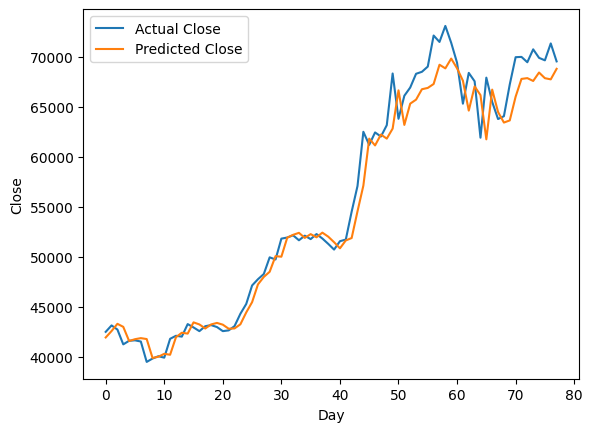

In [195]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [223]:
X_train.shape

torch.Size([1468, 7, 1])

In [207]:
# Suponiendo que X_train es un tensor de la forma (n_samples, seq_length, n_features)
# donde n_samples es el número de muestras, seq_length es la longitud de la secuencia (por ejemplo, 60 días),
# y n_features es el número de características por día.

# Tomar la última muestra de X_train
last_sequence = X_train[-1:]  # Esto conserva las dimensiones del tensor

# Verificar las dimensiones del tensor last_sequence
print(last_sequence.shape)  # Esto debería mostrar algo como (1, seq_length, n_features)

torch.Size([1, 7, 1])


In [209]:
# Mover el modelo al dispositivo seleccionado
model.to(device)

# Antes de la predicción, asegúrate de que el tensor de entrada también esté en el mismo dispositivo
last_sequence = last_sequence.to(device)

# Asumiendo que 'model' es tu modelo LSTM ya entrenado.
model.eval()  # Poner el modelo en modo de evaluación

predictions = []  # Lista para almacenar las predicciones
n_days = 57  # Número de días hacia adelante que deseas predecir

with torch.no_grad():  # No es necesario calcular gradientes
    for _ in range(n_days):
        # Hacer la predicción usando los últimos datos
        predicted_value = model(last_sequence)
        
        # Asumiendo que el modelo devuelve un valor por predicción
        # y que quieres mantener la estructura del tensor para las siguientes predicciones,
        # extraemos el valor predicho y lo almacenamos
        predictions.append(predicted_value.item())  # Convertir a un número y almacenar
        
        # Actualizar la secuencia para la siguiente predicción:
        # Eliminar el dato más antiguo y añadir el nuevo valor predicho
        # Esto mantiene la forma [1, 7, 1] del tensor
        new_data_point = predicted_value.view(1, 1, 1)  # Asegurarse de que tiene la forma correcta
        last_sequence = torch.cat((last_sequence[:, 1:, :], new_data_point), dim=1)

# En este punto, 'predictions' contiene las predicciones de los precios para los próximos 'n_days' días.
predictions

[0.39142119884490967,
 0.39663559198379517,
 0.4018852114677429,
 0.4071679413318634,
 0.41248127818107605,
 0.4178222119808197,
 0.4231872856616974,
 0.4285726547241211,
 0.4339739680290222,
 0.43938636779785156,
 0.4448046088218689,
 0.45022299885749817,
 0.4556354284286499,
 0.4610353708267212,
 0.4664159417152405,
 0.47176992893218994,
 0.47708985209465027,
 0.48236802220344543,
 0.4875966012477875,
 0.49276769161224365,
 0.4978732764720917,
 0.5029054880142212,
 0.5078566074371338,
 0.5127190351486206,
 0.517485499382019,
 0.5221492052078247,
 0.5267035961151123,
 0.5311427712440491,
 0.5354613065719604,
 0.5396543145179749,
 0.543717622756958,
 0.5476477146148682,
 0.5514417886734009,
 0.5550976991653442,
 0.5586138963699341,
 0.5619896650314331,
 0.565224826335907,
 0.5683199167251587,
 0.5712759494781494,
 0.5740945339202881,
 0.5767779350280762,
 0.5793285965919495,
 0.5817495584487915,
 0.5840440988540649,
 0.5862159729003906,
 0.588269054889679,
 0.5902073979377747,
 0.59203

In [210]:
# Asumiendo que el `scaler` fue ajustado en datos con 8 características
# y que tus predicciones están en una lista llamada `predictions`.

# Crear un arreglo dummy con la forma adecuada
# El número '8' debe reemplazarse con el número correcto de características
dummies = np.zeros((len(predictions), 8))  # Rellenar con ceros
dummies[:, 0] = predictions  # Asumiendo que quieres antitransformar las predicciones en la primera característica

# Antitransformar los datos
predictions_inverse = scaler.inverse_transform(dummies)[:, 0]  # Extraer solo la columna de las predicciones antitransformadas
predictions_inverse



array([52357.52371998, 52535.10694882, 52713.8898586 , 52893.80038728,
       53074.75327833, 53256.64602096, 53439.36087997, 53622.76692572,
       53806.71597427, 53991.04258738, 54175.56813235, 54360.09875212,
       54544.42638019, 54728.32874064, 54911.57137807, 55093.90867252,
       55275.08586941, 55454.84110943, 55632.90745852, 55809.01595266,
       55982.89356801, 56154.27235554, 56322.88944099, 56488.48600995,
       56650.81441254, 56809.64323822, 56964.74919613, 57115.93132447,
       57263.00490081, 57405.80347195, 57544.1849437 , 57678.02955096,
       57807.24188763, 57931.74887669, 58051.4977403 , 58166.46411947,
       58276.64192443, 58382.04942444, 58482.7211281 , 58578.71184316,
       58670.09870646, 58756.9649446 , 58839.41408336, 58917.55776816,
       58991.52388377, 59061.44437481, 59127.45727562, 59189.70671032,
       59248.33883292, 59303.50791713, 59355.3662067 , 59404.06391551,
       59449.7492275 , 59492.57641635, 59532.68960617, 59570.23292107,
      

In [217]:
from datetime import datetime, timedelta

# Datos iniciales
fecha_inicio = datetime.strptime("2020-01-01", "%Y-%m-%d")
total_filas = 1553
porcentaje_entrenamiento = 0.95

# Calcular el índice de la última fila en el conjunto de entrenamiento
indice_final_entrenamiento = int(total_filas * porcentaje_entrenamiento)

# Calcular la fecha de la última observación en el conjunto de entrenamiento
fecha_final_entrenamiento = fecha_inicio + timedelta(days=indice_final_entrenamiento - 1)

# Número de días para predecir desde el final del conjunto de entrenamiento
n_days = 57

# Calcular las fechas de predicción
prediction_dates = [(fecha_final_entrenamiento + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(1, n_days + 1)]
fecha_final_entrenamiento.strftime('%Y-%m-%d'), prediction_dates


#############################################

predictions_df = pd.DataFrame({
    'Fecha': prediction_dates,
    'Predicción': predictions_inverse
})
predictions_df['Fecha'] = pd.to_datetime(predictions_df['Fecha'])
# Mostrar la tabla
print(predictions_df)


        Fecha    Predicción
0  2024-01-15  52357.523720
1  2024-01-16  52535.106949
2  2024-01-17  52713.889859
3  2024-01-18  52893.800387
4  2024-01-19  53074.753278
5  2024-01-20  53256.646021
6  2024-01-21  53439.360880
7  2024-01-22  53622.766926
8  2024-01-23  53806.715974
9  2024-01-24  53991.042587
10 2024-01-25  54175.568132
11 2024-01-26  54360.098752
12 2024-01-27  54544.426380
13 2024-01-28  54728.328741
14 2024-01-29  54911.571378
15 2024-01-30  55093.908673
16 2024-01-31  55275.085869
17 2024-02-01  55454.841109
18 2024-02-02  55632.907459
19 2024-02-03  55809.015953
20 2024-02-04  55982.893568
21 2024-02-05  56154.272356
22 2024-02-06  56322.889441
23 2024-02-07  56488.486010
24 2024-02-08  56650.814413
25 2024-02-09  56809.643238
26 2024-02-10  56964.749196
27 2024-02-11  57115.931324
28 2024-02-12  57263.004901
29 2024-02-13  57405.803472
30 2024-02-14  57544.184944
31 2024-02-15  57678.029551
32 2024-02-16  57807.241888
33 2024-02-17  57931.748877
34 2024-02-18  58051

In [222]:
new_y_test.shape, predictions_df.shape

((78,), (57, 2))

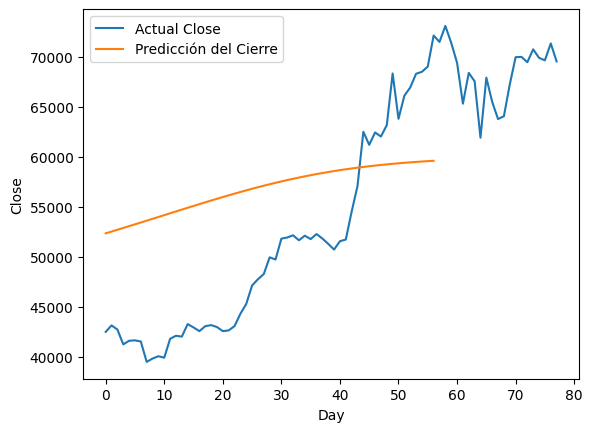

In [220]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(predictions_df['Predicción'], label='Predicción del Cierre')
# plt.plot(predictions_df[1], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()